# EMG spectrogram visualization

This notebook shows how to compute the spectrogram of the EMG samples capture by the Myo armband.

NOTE: you need to install the additional library `librosa` to generate the spectrogram plot.

In [13]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import math
import pandas as pd

In [2]:
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(len(specgram), 1, figsize=(16, 8))

    axs[0].set_title(title or "Spectrogram (db)")

    for i, spec in enumerate(specgram):
        im = axs[i].imshow(librosa.power_to_db(specgram[i]), origin="lower", aspect="auto")
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    axs[i].set_xlabel("Frame number")
    axs[i].get_xaxis().set_visible(True)
    plt.show(block=False)

def plot_signal(signal, title=None, ylabel="time"):
    fig, axs = plt.subplots(len(signal), 1, figsize=(16, 8))

    axs[0].set_title(title or "EMG signal")

    for i, sig in enumerate(signal):
        im = axs[i].plot(range(len(sig)), sig)
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    axs[i].set_xlabel("time")
    axs[i].get_xaxis().set_visible(True)
    plt.show(block=False)

def plot_general(signal):
    plt.plot(signal)
    plt.show()


In [3]:
# Sampling frequency is 160 Hz
# With 32 samples the frequency resolution after FFT is 160 / 32

n_fft = 510
win_length = None
hop_length = 1

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True
)


def compute_spectrogram(signal, title):
    freq_signal = [spectrogram(signal[:, i]) for i in range(8)]
    plot_spectrogram(freq_signal, title=title)
    return freq_signal

In [4]:
# Replace with your path to one of the subjects from Action-Net
emg_annotations = pd.read_pickle("../../an_data/EMG/S00_2.pkl")

sample_no = 1
signal = torch.from_numpy(emg_annotations.iloc[sample_no].myo_left_readings).float()
title = emg_annotations.iloc[sample_no].description

In [15]:
emg_annotations.iloc[sample_no]

description                  Get items from refrigerator/cabinets/drawers
start                                                   1654640077.703751
stop                                                    1654640151.759367
myo_left_timestamps     [1654640077.70674, 1654640077.710727, 16546400...
myo_left_readings       [[-4, -8, -4, 5, 3, 5, 2, -1], [2, 13, 14, 11,...
myo_right_timestamps    [1654640077.704248, 1654640077.707736, 1654640...
myo_right_readings      [[2, 14, -2, 10, 10, -1, 0, -1], [-3, 4, 9, -7...
Name: 1, dtype: object

In [17]:
dur = emg_annotations.iloc[sample_no].stop - emg_annotations.iloc[sample_no].start
print(f"The action last {dur} s")
print(f"The sampling frequency is 160Hz, so we have {math.floor(dur*160)} samples")
print(f"Left: {len(emg_annotations.iloc[sample_no].myo_left_readings)}")
print(f"Right: {len(emg_annotations.iloc[sample_no].myo_right_readings)}")
# Eccedono, bisogna croppare, io direi di farlo subito


The action last 74.05561637878418 s
The sampling frequency is 160Hz, so we have 11848 samples
Left: 11871
Right: 11862


In [27]:
n_clip = 5
dur_clip = math.floor(dur*160/n_clip)

print(f"Each clip has {math.floor(dur_clip)} samples")

Each clip has 2369 samples


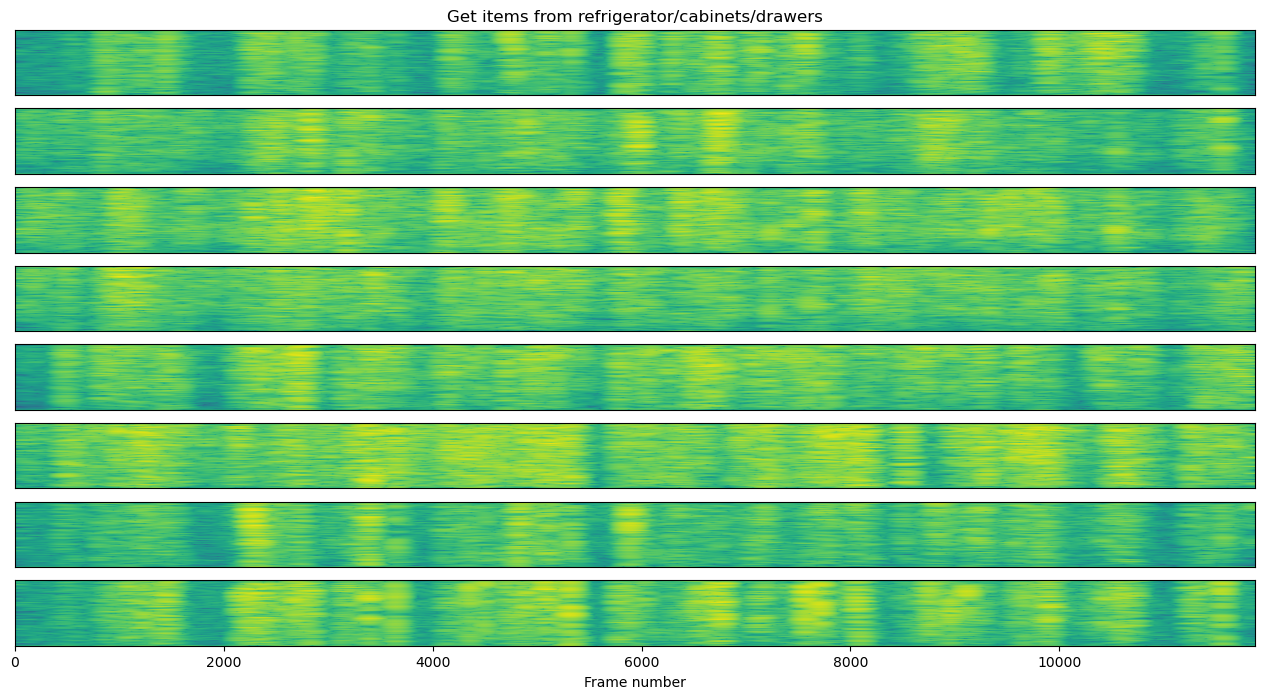

In [34]:
freq = compute_spectrogram(signal, title)

In [41]:
resampler = T.Resample(160, math.floor(2*dur_clip/256))

clip = freq[0]
clip = resampler(clip[:, 0:dur_clip])

clip.shape

torch.Size([256, 267])

In [44]:
total_duration = 0
durations = []
for i in range(len(emg_annotations)):
    sample = emg_annotations.iloc[i]
    durations.append(sample.stop - sample.start)
    total_duration += sample.stop - sample.start

print(f"Avg duration of the action is {total_duration/len(emg_annotations)} s")
print(f"Shorter: {min(durations)} s")
print(f"Longer: {max(durations)} s")

Avg duration of the action is 37.481644765386044 s
Shorter: 7.3882904052734375 s
Longer: 189.17883014678955 s
